This is the first example in the course **Time Series** on Kaggle.

I've found the original data and will reproduce the whole process, as well as try to explore various components in the time series and add some of my own thoughts. 

## 1. Problem Definition

> How can we predict next day's tunnel traffic based on historical time series data?

## 2. Data

**Tunnel Traffic** is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005. 

In this example, we'll get some practice applying linear regression to time-step features and lag features.

In [6]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

In [2]:
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
# Load Tunnel Traffic dataset
tunnel = pd.read_csv("tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date column. 
# We parsed "Day" as a date type by using `parse_dates` when loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

In [4]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [20]:
tunnel.describe()

,NumVehicles
count,747.00000
mean,106567.75502
std,12456.35049
min,53098.00000
25%,98794.00000
50%,108204.00000
75%,115477.00000
max,139840.00000


## 3. Features and Data Feature Engineering

**Time-step feature**

Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [5]:
df = tunnel.copy() # create a copy so that the original won't be modified

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


## 4. Modeling with time-step feature

The procedure for fitting a linear regression model follows the standard steps for **scikit-learn**.

In [7]:
# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [11]:
model.coef_

array([22.49744953])

In [13]:
model.intercept_

98176.20634409295

The model actually created is (approximately): 

Vehicles = 22.5 * Time + 98176. 

Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

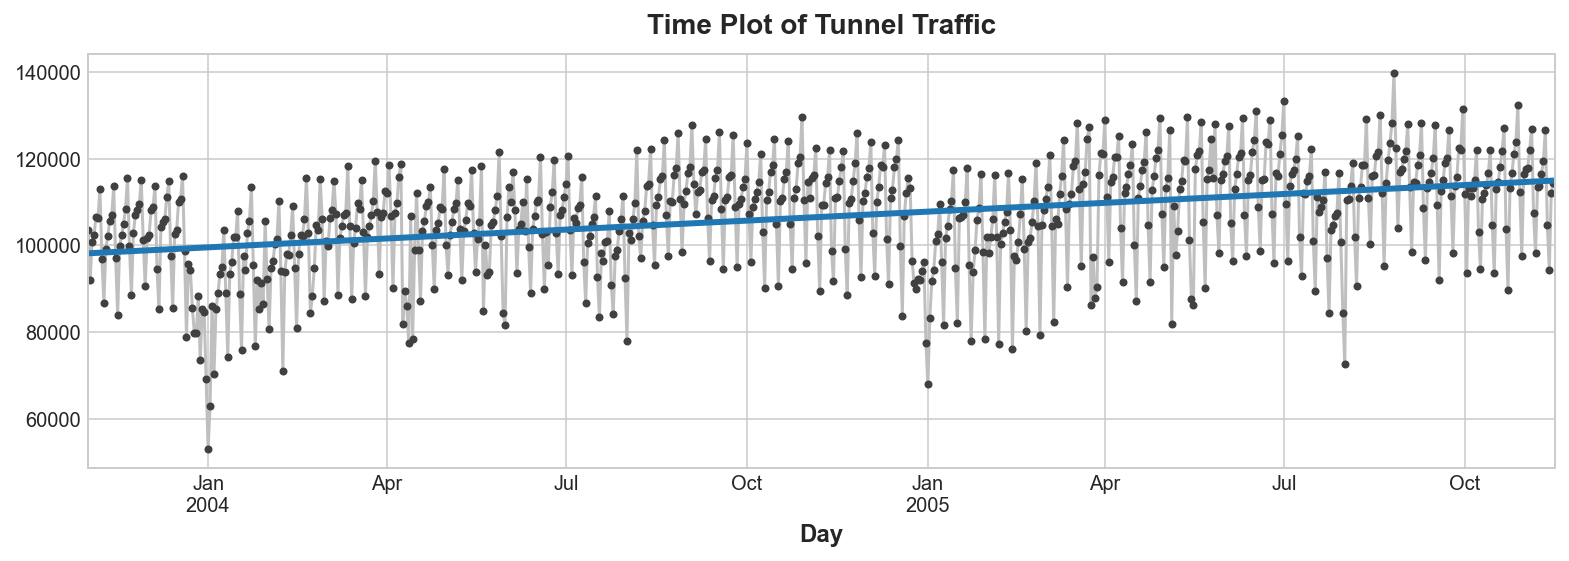

In [14]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

## 5. Lag feature

**Lag feature**

Pandas provides us a simple method to lag a series, the shift method.

In [15]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


## 6. Missing Data and Modeling with Lag Feature

When creating lag features, we need to decide what to do with the **missing values** produced. 

Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. 

Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [16]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [17]:
model.coef_, model.intercept_

(array([0.53296606]), 49780.624869069565)

The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

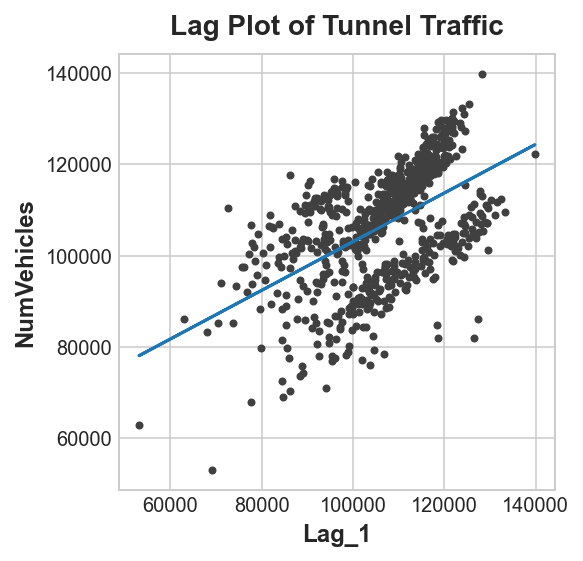

In [18]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

## 7. Result Interpretation Part 1

What does this prediction from a lag feature mean about how well we can predict the series across time? The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

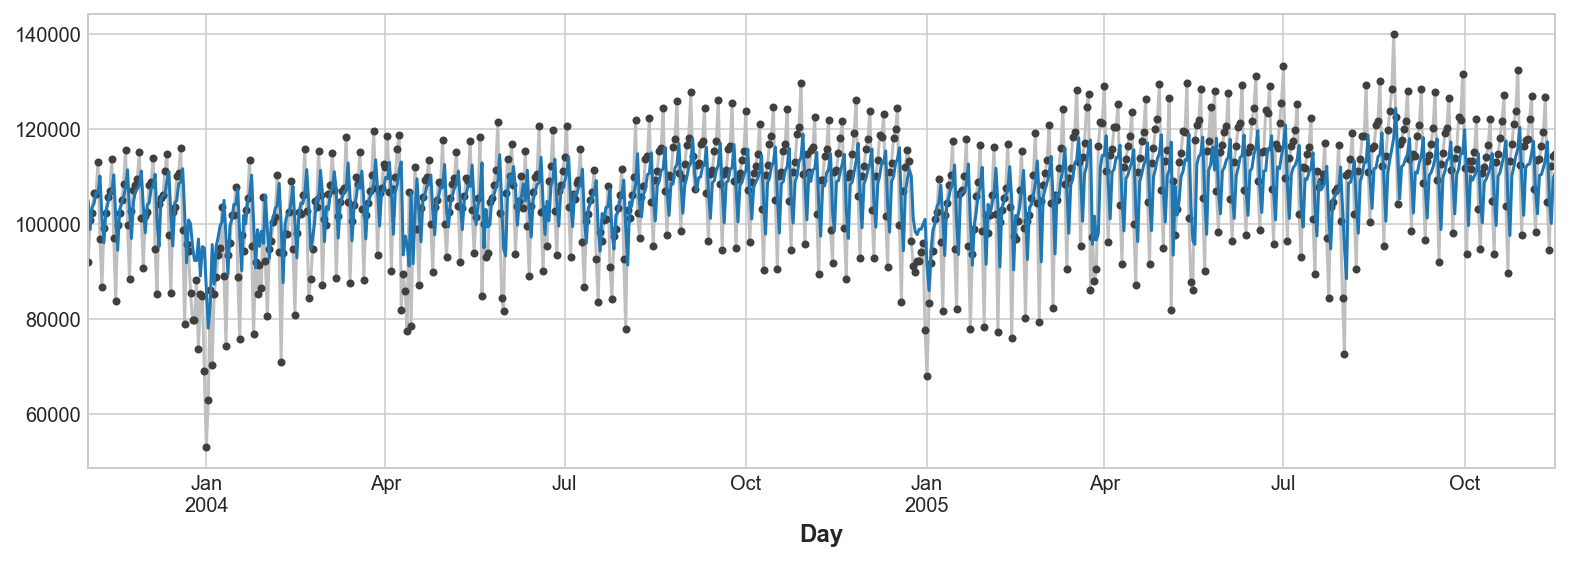

In [19]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

The best time series models will usually include some combination of **time-step features** and **lag features**. 

Over the next few lessons, we'll learn how to engineer features modeling the most common patterns in time series using the features from this lesson as a starting point.

## 8. Trend

Let's make a **moving average plot** to see what kind of trend this series has. Since this series has daily observations, let's choose a window of **365 days** to smooth over any short-term changes within the year.

To create a moving average, first use the **rolling** method to begin a windowed computation. Follow this by the **mean** method to compute the average over the window. 

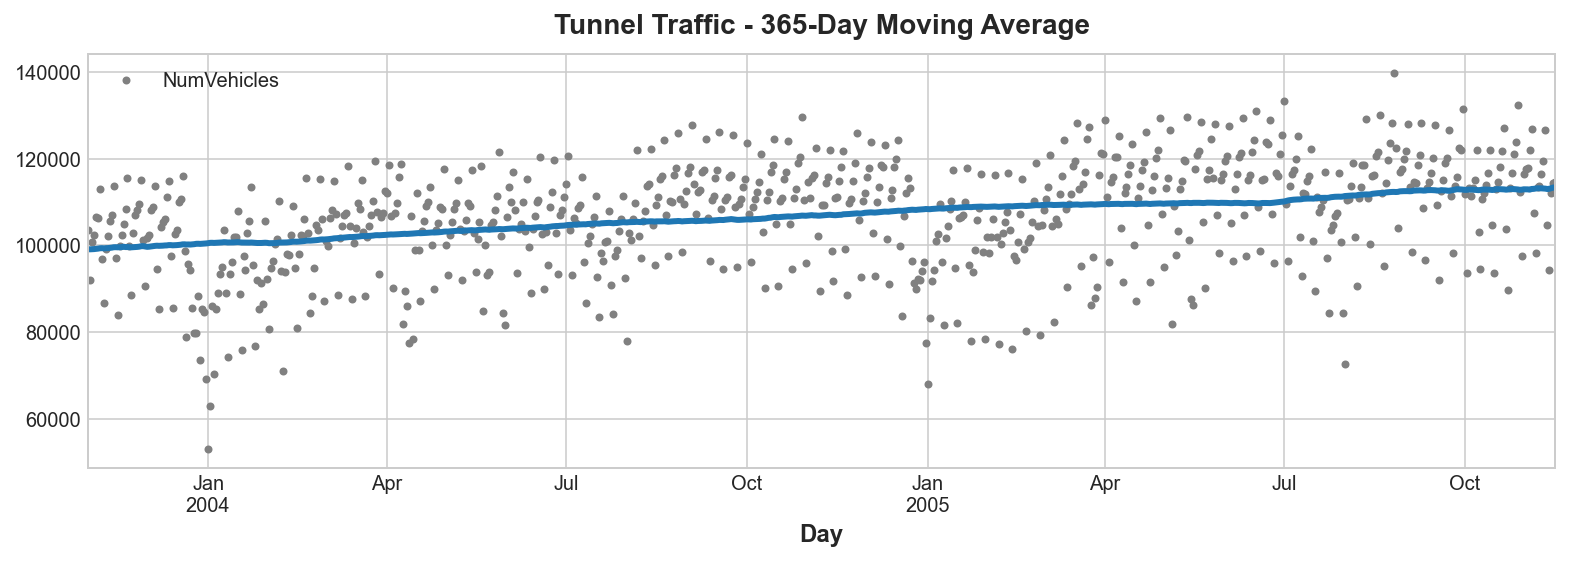

In [21]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

As we can see, the trend of Tunnel Traffic appears to be about **linear**.

**Note**:
If the trend is upwards bend, it suggests an **order 2 (quadratic) polynomial** might be appropriate.

If you've worked with economic time series before, you might guess that the growth rate in Food and Beverage Sales is best expressed as a **percent change**. Percent change can often be modeled using an **exponential** curve. 

Previously, we engineered our time dummy in Pandas **directly**. However, from now on, we'll use a function from the statsmodels library called **DeterministicProcess**. 

Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. 

The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

**Note**: 
One way to fit more complicated trends is to **increase the order of the polynomial** you use. To get a better fit to the somewhat complicated trend in data, we could try using a high order such as 11 polynomial. An order 11 polynomial will include terms like t ** 11. However, terms like these tend to **diverge rapidly** outside of the training period making forecasts **very unreliable**.

In [22]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


A deterministic process is a technical term for a time series that is **non-random** or **completely determined**, like the const and trend series are. Features derived from the time index will generally be deterministic.

We create our trend model basically as before, though note the addition of the `fit_intercept = False` argument.

In [23]:
y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

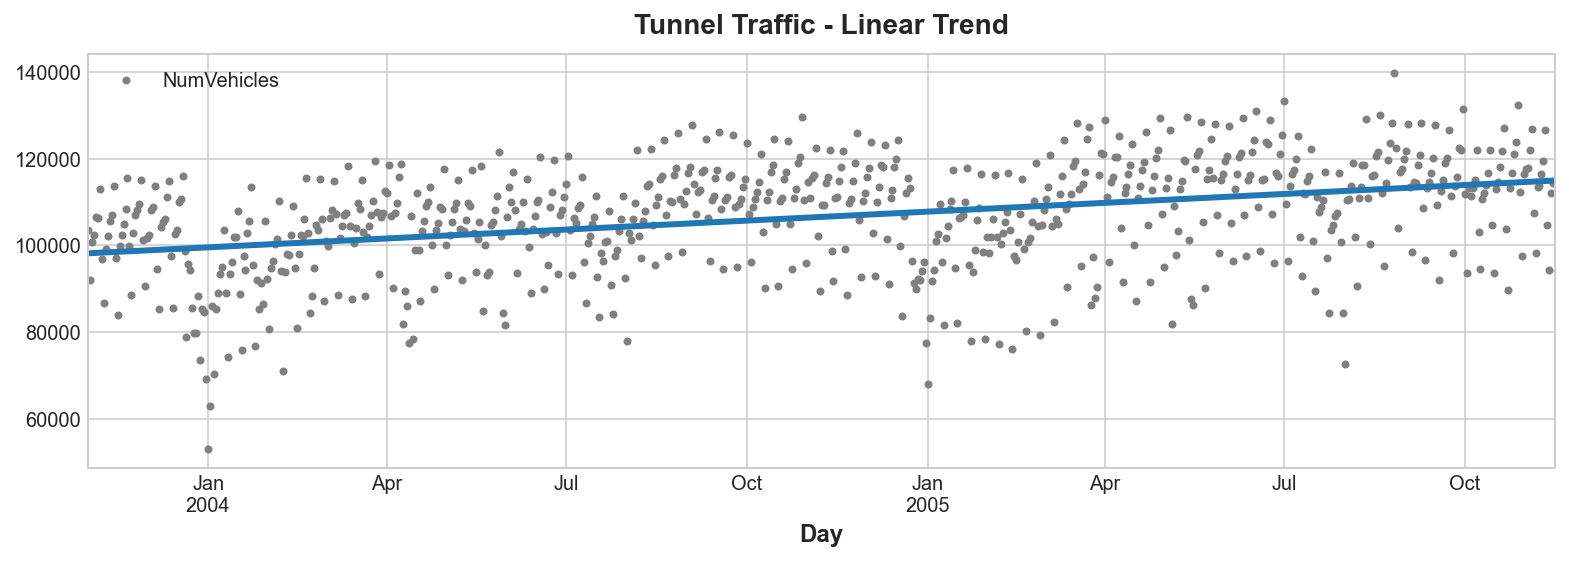

In [24]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

## 9. Make Predictions

To make a forecast, we apply our model to "out of sample" features. **"Out of sample"** refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [25]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Let's plot a portion of the series to see the trend forecast for the next 30 days:

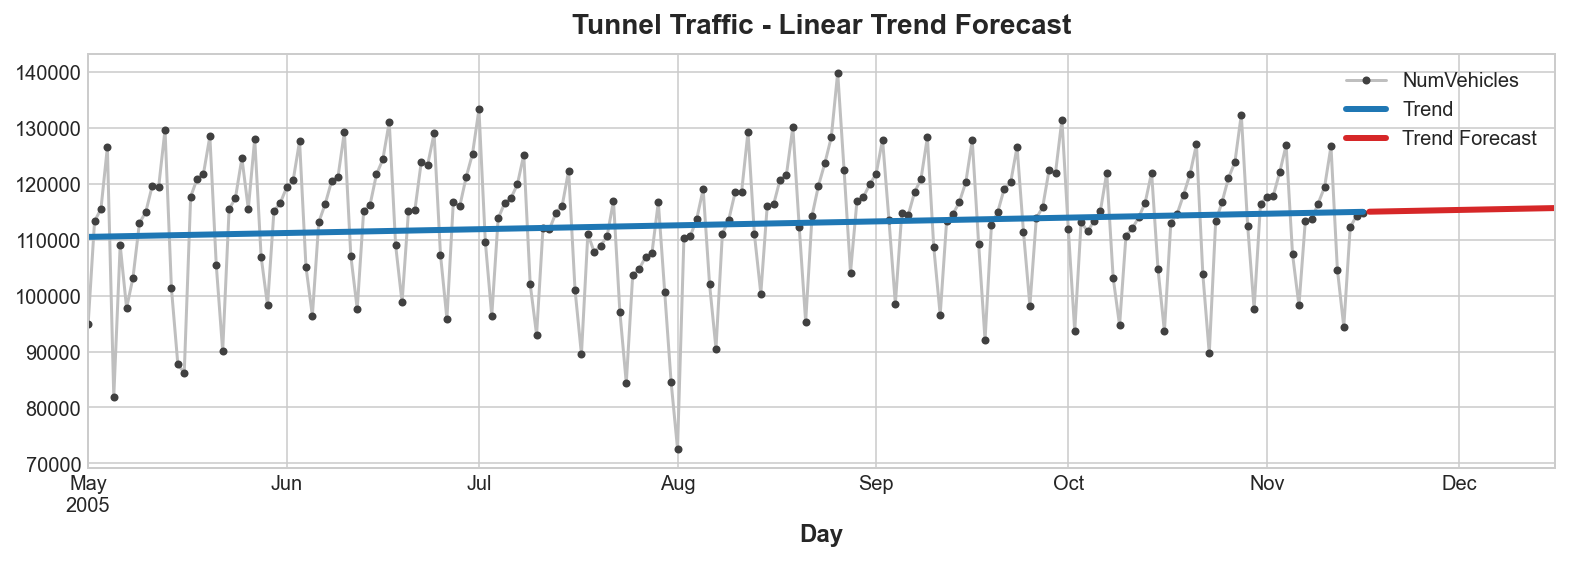

In [26]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

The trend models we learned about in this lesson turn out to be useful for a number of reasons. 

Besides acting as a baseline or starting point for more sophisticated models, we can also use them as a component in a "hybrid model" with algorithms unable to learn trends (like XGBoost and random forests). We'll learn more about this technique later.

## 10. Seasonality

In [29]:
# define two functions: seasonal_plot and plot_periodogram
import seaborn as sns

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


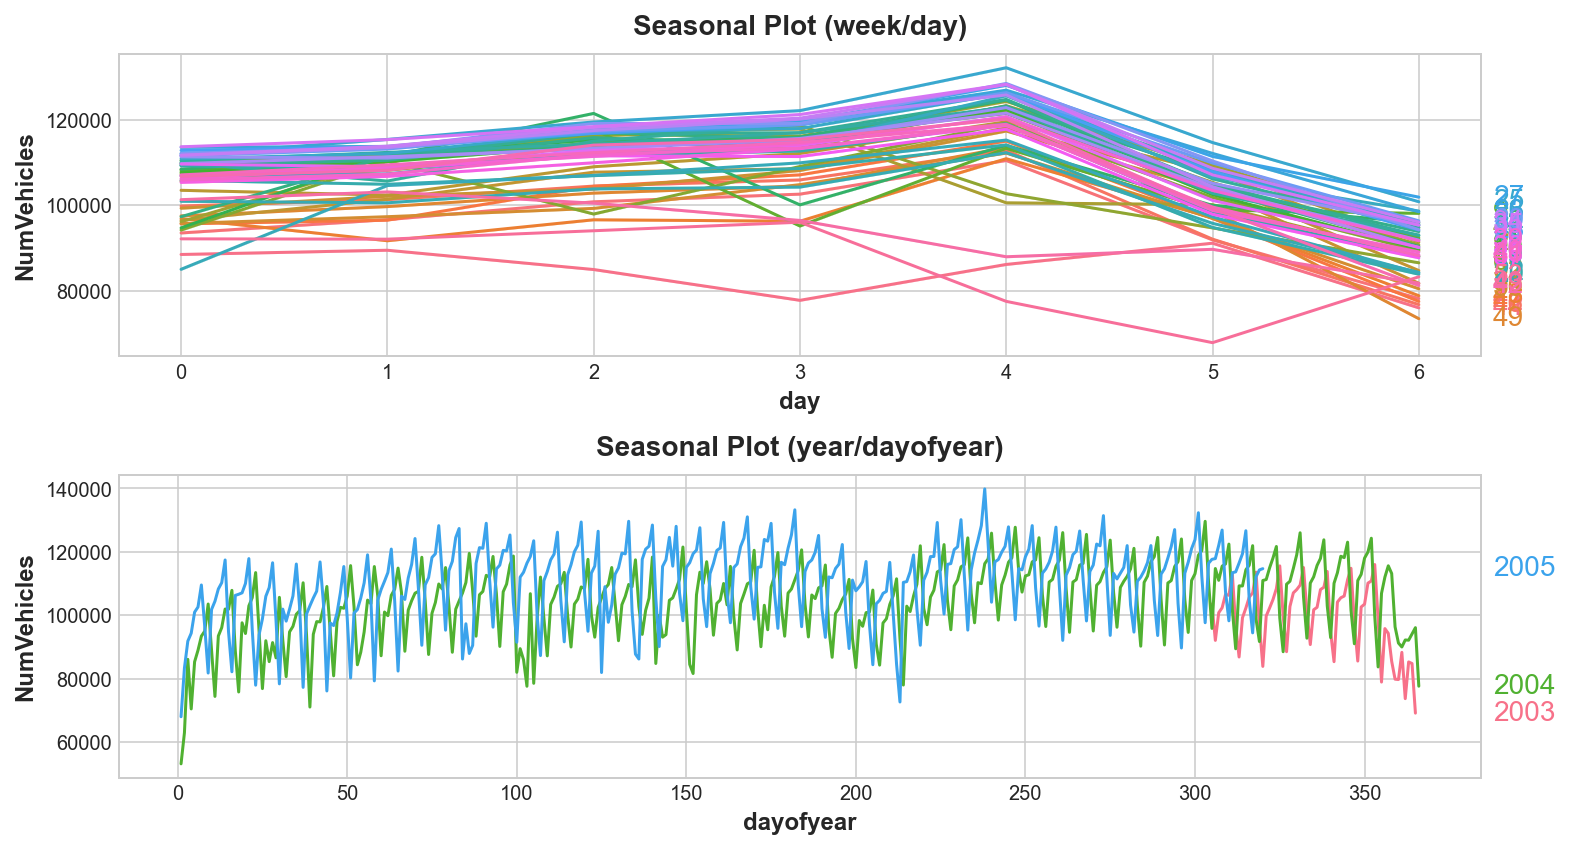

In [30]:
# Let's take a look at seasonal plots over a week and over a year.
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

Now let's look at the periodogram:

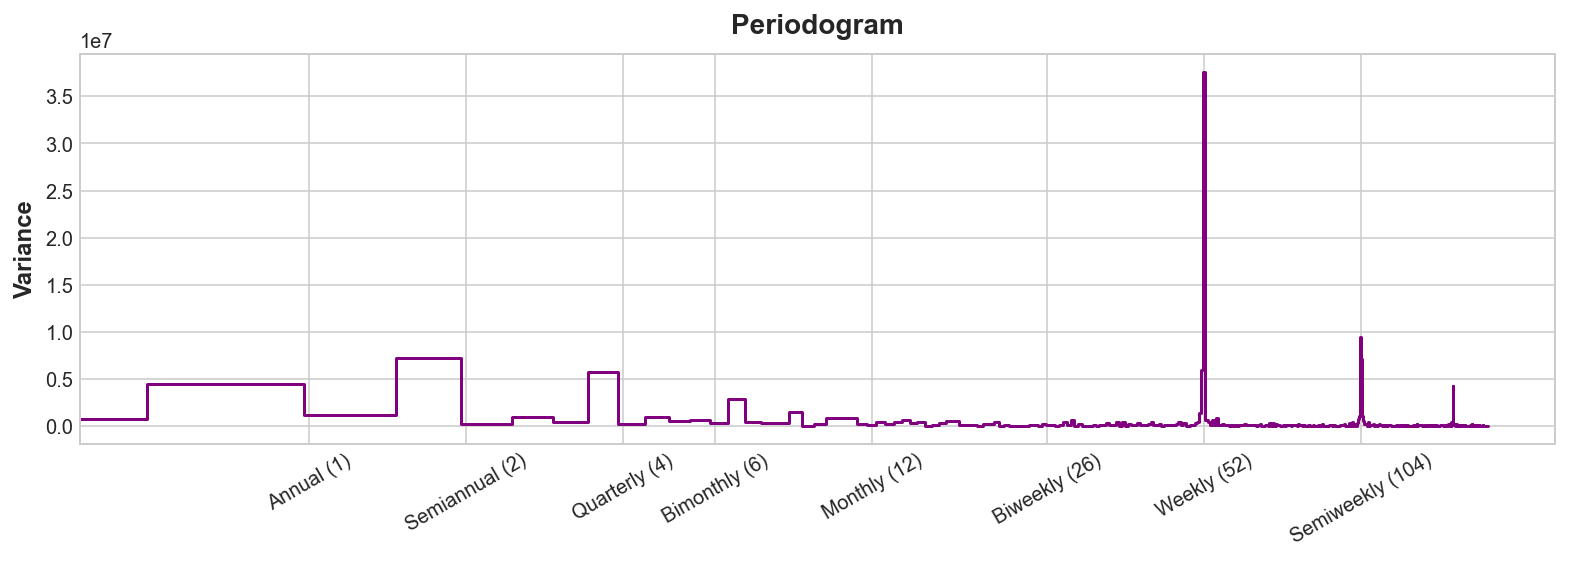

In [32]:
plot_periodogram(tunnel.NumVehicles);

The periodogram agrees with the **seasonal plots** above: a strong weekly season and a weaker annual season. 

The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram **falls off between Bimonthly (6) and Monthly (12)**, so let's use 10 Fourier pairs.

We'll create our seasonal features using **DeterministicProcess**, the same utility we used previously to create trend features. 

To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [33]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

With our feature set created, we're ready to **fit the model and make predictions**. 

We'll add a 90-day forecast to see how our model extrapolates beyond the training data. 

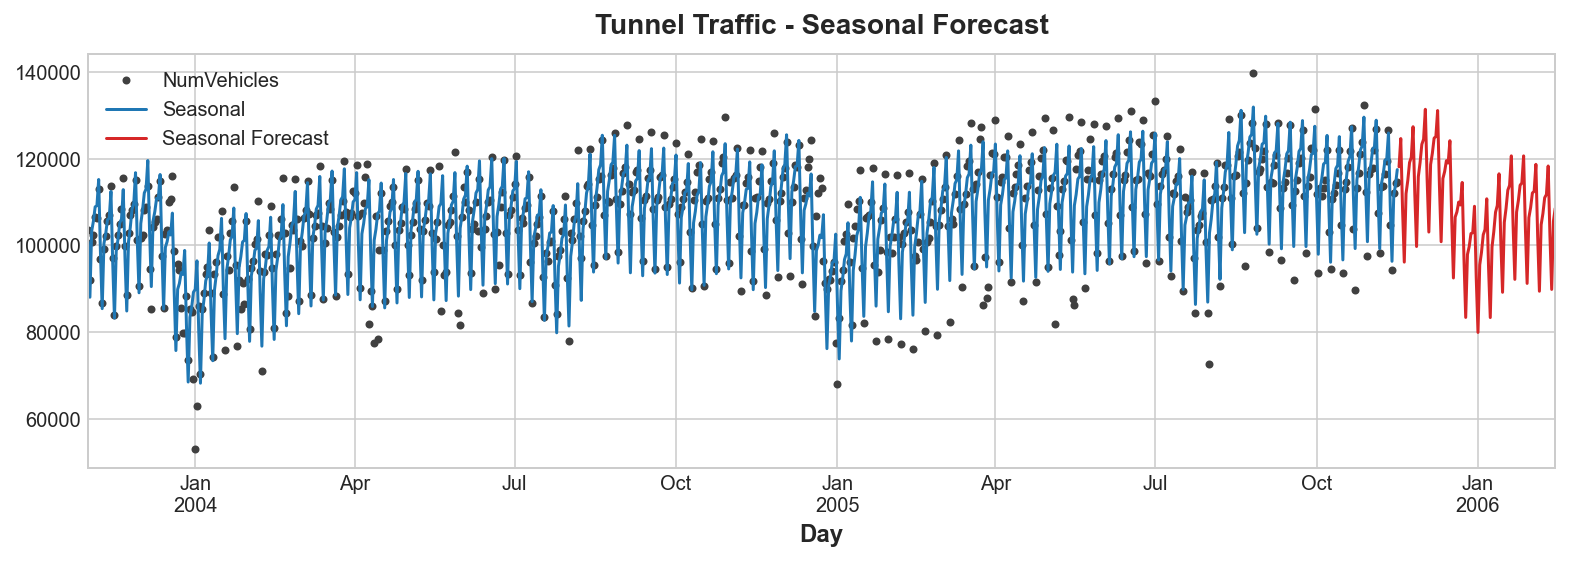

In [34]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

There's still more we can do with time series to improve our forecasts. 

Next, we'll learn how to use time series themselves as a features. Using time series as inputs to a forecast lets us model the another component often found in series: **cycles**.